In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [149]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])

display(house_df.shape)

(9974, 20)

In [199]:
#house_df2=house_df.set_index(['year', 'state', 'district', 'name']).dropna().copy()
#house_df2=house_df.dropna().copy()
#house_df2_districts=house_df2[['state','district']]
#house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
#house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
#house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
#house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])
#data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

#x_train, y_train=data_train.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_train['won']
#x_test, y_test=data_test.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_test['won']
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    dfcopy['party']=dfcopy['party'].replace(['D', 'R'], [0, 1])
    dfcopy['president_party']=dfcopy['president_party'].replace(['D', 'R'], [0, 1])
    dfcopy['last_house_majority']=dfcopy['last_house_majority'].replace(['D', 'R'], [0, 1])
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts
x_train, y_train, x_test, y_test = splitDf(house_df, 2018, indexed_districts)

In [152]:
x_test.head()

,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
9130,1.0,0,2018,2012.0,3,3.7,0.0,1.0,1,0.395,194.0,241.0,1,4606209.66
9131,0.0,0,2018,0.0,0,3.7,0.0,1.0,1,0.395,194.0,241.0,1,109604.65
9132,1.0,0,2018,2014.0,2,3.7,0.0,1.0,1,0.395,194.0,241.0,1,2046673.91
9133,1.0,0,2018,2012.0,3,3.7,0.0,1.0,1,0.395,194.0,241.0,1,543906.56
9134,1.0,1,2018,2014.0,2,3.7,0.0,1.0,1,0.395,194.0,241.0,1,891968.14


In [191]:
def modelAccuracy(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=len(districtWinners[districtWinners['won_pred']!=1])
    assert NotJustOneWinner == 0, "Some districts have no winner or more than one winner"
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [198]:
baselineLogRegr=LogisticRegressionCV(cv=5, penalty='l2').fit(x_train, y_train)

Accu_train, Accu_val, Accu_val_2, pred_df = modelAccuracy(baselineLogRegr, x_train, x_test, y_train, y_test, house_df2_districts)
#print scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
display(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])


Training accuracy: 97.38%
Validation accuracy: 97.02%
Mutually exclusive validation accuracy: 98.10%

N. Democrat districts: 222
N. Republican districts: 213


,state,district,party,abs_won_proba,won_pred,rel_won_proba
9164,Utah,District 4,0.0,0.959111,1.0,0.500783
9171,Utah,District 4,1.0,0.956111,0.0,0.499217
9175,Texas,District 32,1.0,0.952641,0.0,0.498487
9194,Texas,District 32,0.0,0.958424,1.0,0.501513
9232,Virginia,District 7,0.0,0.959660,1.0,0.500233
9256,Virginia,District 7,1.0,0.958765,0.0,0.499767
9268,Virginia,District 10,1.0,0.952750,0.0,0.498510
9269,Virginia,District 10,0.0,0.958444,1.0,0.501490
9301,Texas,District 7,0.0,0.961171,1.0,0.501745
9305,Texas,District 7,1.0,0.954488,0.0,0.498255


(array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 460.]),
 array([3.30403100e-05, 9.62975392e-02, 1.92562038e-01, 2.88826537e-01,
        3.85091036e-01, 4.81355535e-01, 5.77620034e-01, 6.73884533e-01,
        7.70149032e-01, 8.66413531e-01, 9.62678029e-01]),
 <a list of 10 Patch objects>)

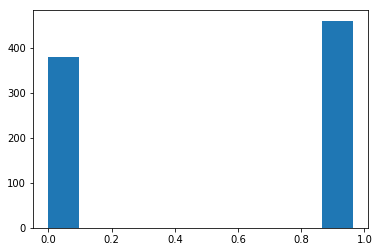

In [194]:
plt.hist(pred_df['abs_won_proba'])

(array([380.,   0.,   0.,   0.,  25.,  25.,   0.,   0.,   0., 410.]),
 array([3.48746356e-05, 1.00031387e-01, 2.00027900e-01, 3.00024412e-01,
        4.00020925e-01, 5.00017437e-01, 6.00013950e-01, 7.00010462e-01,
        8.00006975e-01, 9.00003487e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

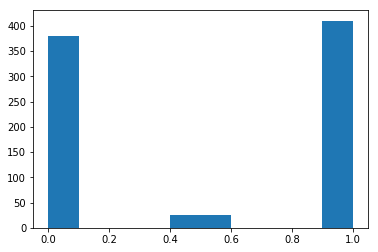

In [195]:
plt.hist(pred_df['rel_won_proba'])